In [17]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
matplotlib.style.use('ggplot')

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset):
  dataX, dataY = [], []
  for i in range(len(dataset)-1):
    dataX.append(dataset[i])
    dataY.append(dataset[i + 1])
  return np.asarray(dataX), np.asarray(dataY)

In [3]:
#connect to poloniex public api
polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1356998100&end=9999999999&period=86400'
df = pd.read_json(polo_url)
eth_df = df.drop(['date','open','high','low','volume','quoteVolume','weightedAverage'], axis=1)
dataset = eth_df.values
dataset = dataset.astype('float32')

In [4]:
#normalize dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
#prepare the X and Y label
X,y = create_dataset(dataset)

In [6]:
#Take 80% of data as the training sample and 20% as testing sample
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, shuffle=False)

In [37]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(output_dim=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  after removing the cwd from sys.path.


Epoch 1/5
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0364
Epoch 2/5
1031/1031 [==============================] - 2s 2ms/step - loss: 0.0064
Epoch 3/5
1031/1031 [==============================] - 2s 2ms/step - loss: 3.6650e-04
Epoch 4/5
1031/1031 [==============================] - 2s 2ms/step - loss: 3.4160e-04
Epoch 5/5
1031/1031 [==============================] - 2s 2ms/step - loss: 3.3599e-04


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

futurePredict = model.predict(np.asarray([[testPredict[-1]]]),steps=1)
futurePredict = scaler.inverse_transform(futurePredict)


In [10]:
# invert predictions to return output back dollar amounts
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [11]:
print("Price for last 5 days: ")
print(testPredict[-5:])
print("Ethereum price for tomorrow: ", futurePredict)

Price for last 5 days: 
[[119.95368 ]
 [119.51732 ]
 [117.922035]
 [118.93465 ]
 [120.27235 ]]
Ethereum price for tomorrow:  [[117.84889]]


In [12]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.27 RMSE
Test Score: 13.74 RMSE


In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict


In [15]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):len(dataset)-1, :] = testPredict

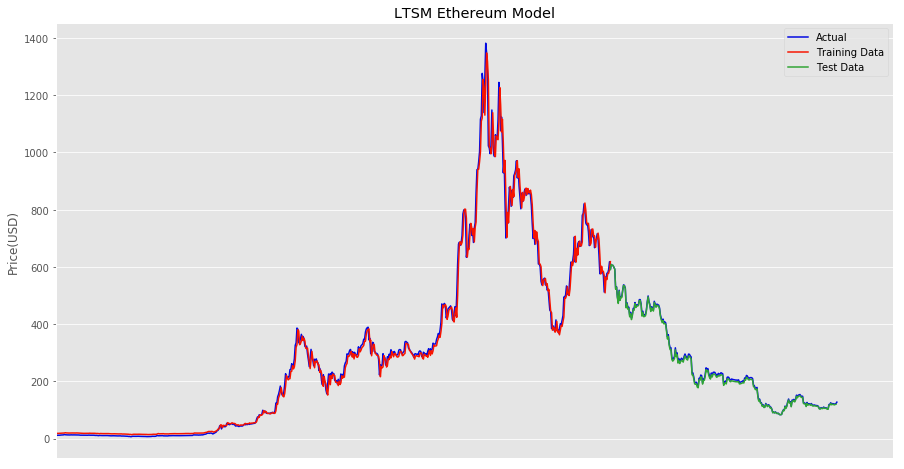

In [38]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = 'Actual', color = '#0209e2')
plt.plot(trainPredictPlot,label= 'Training Data', color = '#f71400')
plt.plot(testPredictPlot, label = 'Test Data', color = '#30a535')
plt.xlim(xmin=400 )
plt.xticks([])
plt.legend()
plt.title("LTSM Ethereum Model")
plt.ylabel('Price(USD)')
plt.show()